__Sequence to Sequence for Neural Machne Translation.__

*This notebook is based on [open-source implementation](https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb) of seq2seq NMT in PyTorch.*

We are going to implement the model from the [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215) paper. 

The model will be trained for German to English translations, but it can be applied to any problem that involves going from one sequence to another, such as summarization.

In [1]:
import time
import random
import math
import gzip
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# from IPython.display import clear_output

import pandas as pd
# from sklearn.model_selection import train_test_split
import spacy

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
# from torch.utils.tensorboard import SummaryWriter

In [3]:
from torchtext.data import Field
from torchtext.data import BucketIterator

from torchtext.data import Example
from torchtext.data import TabularDataset

In [4]:
# matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
# %matplotlib inline

## загружаем данные

In [5]:
# список фраз на английском с переводом на русский
with gzip.open('../data/rus-eng/rus.txt.gz', 'rt', encoding='utf-8') as f:
    data = f.read().split('\n')
print(len(data))
data = pd.DataFrame([ s.split('\t') for s in data ],columns=['src','trg'])
data.sample(3)

336667


,src,trg
224864,Tom didn't come home that night.,Том в ту ночь не пришёл домой.
10559,Suit yourself.,Воля твоя.
309454,"If it were not for the sun, we would all die.","Если б не солнце, мы бы все умерли."


In [6]:
# ограничиваем набор данных для ускорения процесса
data = data.sample(50000).reset_index(drop=True)

In [7]:
# !mkdir tmp

In [8]:
data.to_csv('tmp/data_train.csv', index=False, sep='\t')

---

In [9]:
# инициализируем пакет Torch
SEED = 8432
random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [10]:
# создаём препроцессор для текстов
spacy_en = spacy.load('en_core_web_sm')
spacy_ru = spacy.load('ru_core_news_sm')

def tokenize_en(text): return [tok.text for tok in spacy_en.tokenizer(text)]
def tokenize_ru(text): return [tok.text for tok in spacy_ru.tokenizer(text)]

SRC = Field(tokenize = tokenize_en, init_token = '<sos>', eos_token = '<eos>', lower = True)
TRG = Field(tokenize = tokenize_ru, init_token = '<sos>', eos_token = '<eos>', lower = True)

/usr/lib/python3.9/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [11]:
# загружаем датасет в формате Torch
# и выполняем предобработку данных
fields = [('src',SRC),('trg',TRG)]
(train_data,) = TabularDataset.splits(
                            path = 'tmp',
                            train = 'data_train.csv',
                            format = 'tsv', #'tsv' for tabs, 'csv' for commas
                            fields = fields
)

/usr/lib/python3.9/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/usr/lib/python3.9/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


In [12]:
# количество примеров
len(train_data.examples)

50001

In [13]:
# словари 
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [15]:
# раскидываем данные по батчам,
# в один батч будут помещены тексты одинаковой (или близкой) длинны

BATCH_SIZE = 128

(train_iterator,) = BucketIterator.splits(
    (train_data,), 
    batch_size = BATCH_SIZE, 
    device = device)

/usr/lib/python3.9/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [16]:
# # пример батча
# for x in train_iterator:  break
# print(x)
# print(x.src.shape, x.trg.shape)

## строим модель

In [18]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, n_layers, dropout):
        super().__init__()
        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.input_dim = input_dim
        self.n_layers = n_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, n_layers, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)

    def forward(self, src_batch):
        # src [sent len, batch size]

        # [sent len, batch size, emb dim]
        embedded = self.embedding(src_batch)
        outputs, hidden = self.rnn(embedded)
        # outputs -> [sent len, batch size, hidden dim * n directions]
        # hidden -> [n layers * n directions, batch size, hidden dim]

        # initial decoder hidden is final hidden state of the forwards and
        # backwards encoder RNNs fed through a linear layer
        concated = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        hidden = torch.tanh(self.fc(concated))
        return outputs, hidden

In [19]:
class Attention(nn.Module):

    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim

        # enc_hid_dim multiply by 2 due to bidirectional
        self.fc1 = nn.Linear(enc_hid_dim * 2 + dec_hid_dim, dec_hid_dim)
        self.fc2 = nn.Linear(dec_hid_dim, 1, bias=False)

    def forward(self, encoder_outputs, hidden):
        src_len = encoder_outputs.shape[0]
        batch_size = encoder_outputs.shape[1]
        
        # repeat encoder hidden state src_len times [batch size, sent len, dec hid dim]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        # reshape/permute the encoder output, so that the batch size comes first
        # [batch size, sent len, enc hid dim * 2], times 2 because of bidirectional
        outputs = encoder_outputs.permute(1, 0, 2)

        # the attention mechanism receives a concatenation of the hidden state
        # and the encoder output
        concat = torch.cat((hidden, outputs), dim=2)
        
        # fully connected layer and softmax layer to compute the attention weight
        # [batch size, sent len, dec hid dim]
        energy = torch.tanh(self.fc1(concat))

        # attention weight should be of [batch size, sent len]
        attention = self.fc2(energy).squeeze(dim=2)        
        attention_weight = torch.softmax(attention, dim=1)
        return attention_weight

In [20]:
class Decoder(nn.Module):

    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, n_layers,
                 dropout, attention):
        super().__init__()
        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout = dropout
        self.attention = attention

        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU(enc_hid_dim * 2 + emb_dim, dec_hid_dim, n_layers, dropout=dropout)
        self.linear = nn.Linear(dec_hid_dim, output_dim)

    def forward(self, trg, encoder_outputs, hidden):
        # trg [batch size]
        # outputs [src sen len, batch size, enc hid dim * 2], times 2 due to bidirectional
        # hidden [batch size, dec hid dim]

        # [batch size, 1, sent len] 
        attention = self.attention(encoder_outputs, hidden).unsqueeze(1)

        # [batch size, sent len, enc hid dim * 2]
        outputs = encoder_outputs.permute(1, 0, 2)

        # [1, batch size, enc hid dim * 2]
        context = torch.bmm(attention, outputs).permute(1, 0, 2)

        # input sentence -> embedding
        # [1, batch size, emb dim]
        embedded = self.embedding(trg.unsqueeze(0))
        rnn_input = torch.cat((embedded, context), dim=2)

        outputs, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        prediction = self.linear(outputs.squeeze(0))
        return prediction, hidden.squeeze(0)

In [21]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src_batch, trg_batch, teacher_forcing_ratio=0.5):
        max_len, batch_size = trg_batch.shape
        trg_vocab_size = self.decoder.output_dim

        # tensor to store decoder's output
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)

        # encoder_outputs : all hidden states of the input sequence (forward and backward)
        # hidden : final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src_batch)

        trg = trg_batch[0]
        for i in range(1, max_len):
            prediction, hidden = self.decoder(trg, encoder_outputs, hidden)
            outputs[i] = prediction

            if random.random() < teacher_forcing_ratio:
                trg = trg_batch[i]
            else:
                trg = prediction.argmax(1)

        return outputs

In [25]:
# adjustable parameters
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
N_LAYERS = 1
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5


In [26]:
attention = Attention(ENC_HID_DIM, DEC_HID_DIM)
encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, N_LAYERS, ENC_DROPOUT)
decoder = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, N_LAYERS, DEC_DROPOUT, attention)
seq2seq = Seq2Seq(encoder, decoder, device).to(device)
seq2seq

/usr/lib/python3.9/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(5015, 256)
    (rnn): GRU(256, 512, dropout=0.5, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
  )
  (decoder): Decoder(
    (attention): Attention(
      (fc1): Linear(in_features=1536, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(10308, 256)
    (rnn): GRU(1280, 512, dropout=0.5)
    (linear): Linear(in_features=512, out_features=10308, bias=True)
  )
)

## процесс обучения модели

In [28]:
optimizer = optim.Adam(seq2seq.parameters())

# ignore the padding index when calculating the loss
PAD_IDX = TRG.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [29]:
def train(seq2seq, iterator, optimizer, criterion):
    seq2seq.train()
    
    epoch_loss = 0
    for batch in iterator:
        optimizer.zero_grad()
        outputs = seq2seq(batch.src, batch.trg)

        # the loss function only works on 2d inputs
        # and 1d targets we need to flatten each of them
        outputs_flatten = outputs[1:].view(-1, outputs.shape[-1])
        trg_flatten = batch.trg[1:].view(-1)
        loss = criterion(outputs_flatten, trg_flatten)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

---

In [30]:
N_EPOCHS = 10
#best_valid_loss = float('inf')
train_history=[]

for epoch in range(N_EPOCHS):
    # start_time = time.time()
    train_loss = train(seq2seq, train_iterator, optimizer, criterion)
    train_history.append(train_loss)

    # valid_loss = evaluate(seq2seq, valid_iterator, criterion)
    # end_time = time.time()
    #epoch_mins, epoch_secs = epoch_time(start_time, end_time)

#     if valid_loss < best_valid_loss:
#         best_valid_loss = valid_loss
#         torch.save(seq2seq.state_dict(), 'tut2-model.pt')

#     print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
#     print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
#     print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

    print(f'Epoch: {epoch+1:02}\tTrain Loss: {train_loss:.3f}')

/usr/lib/python3.9/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch: 01	Train Loss: 4.325
Epoch: 02	Train Loss: 2.706
Epoch: 03	Train Loss: 1.914
Epoch: 04	Train Loss: 1.438
Epoch: 05	Train Loss: 1.097
Epoch: 06	Train Loss: 0.867
Epoch: 07	Train Loss: 0.694
Epoch: 08	Train Loss: 0.552
Epoch: 09	Train Loss: 0.447
Epoch: 10	Train Loss: 0.370


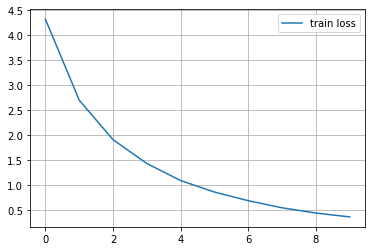

In [62]:
plt.grid()
plt.plot(train_history,label='train loss')
plt.legend()

## проверяем результаты

In [55]:
def translate_sentence(sentence, 
                       src_field, 
                       trg_field, 
                       model, 
                       device, 
                       max_len=50,
                       spacy_lang_mod = 'ru_core_news_sm'
                      ):
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load(spacy_lang_mod)
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)
    src_len = torch.LongTensor([len(src_indexes)]).to(device)
    
    with torch.no_grad():  
        # hidden, cell = model.encoder(src_tensor)
        outputs, hidden = model.encoder(src_tensor)
        
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for t in range(1, max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        # output, hidden, cell = model.decoder(trg_tensor, hidden, cell)
        output, hidden = model.decoder(trg_tensor, outputs, hidden )
        
        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]: break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:]

In [57]:
def get_example_translation():
    example_idx = np.random.choice(np.arange(len(train_data)))
    src = vars(train_data.examples[example_idx])['src']
    trg = vars(train_data.examples[example_idx])['trg']
    
    translation = translate_sentence(src, SRC, TRG, seq2seq, device)
   
    return [' '.join(src),' '.join(trg),' '.join(translation)]

In [61]:
# get_example_translation()

In [60]:
from tabulate import tabulate 

tabulate(
    [ get_example_translation() for i in range(20) ], 
    headers=['src', 'trg', 'pred'], 
    tablefmt='html', 
    showindex='always'
)

,src,trg,pred
0,""" you dislike tom , do n't you ? "" "" it 's not that i dislike like him , it 's just that i kind of have trouble dealing with people like him . """,""" ты не любишь тома ? "" - "" не то чтобы не люблю - мне просто немного трудно иметь дело с такими людьми "" .",""" ты не любишь тома ? "" - "" не люблю мне просто немного с с с с людьми с ним людьми с людьми . <eos>"
1,would you like a newspaper or magazine ?,вам газету или журнал ?,вам газету или журнал ? <eos>
2,tom gets very animated when he 's watching rugby on tv .,"том очень оживляется , когда смотрит регби по телевизору .","том очень <unk> , когда смотрит <unk> по телевизору . <eos>"
3,i never lie to you .,я никогда тебе не вру .,я никогда тебе не вру . <eos>
4,tom asked for money .,том просил денег .,том попросил денег . <eos>
5,are you sure tom is going to win ?,"вы уверены , что том победит ?","ты уверен , что том победит ? <eos>"
6,what time did you see tom ?,в какое время ты видел тома ?,в какое ты видел тома ? <eos>
7,you do n't have to worry . i 'll do it myself .,можете не беспокоиться . я сам это сделаю .,не нужно беспокоиться . я сам это сам . <eos>
8,tell us who you are .,"расскажите нам , кто вы .","расскажите нам , кто вы . <eos>"
9,how long will it take to you ?,сколько это у тебя займёт ?,сколько это у тебя займёт ? <eos>


---

In [31]:
# # инициализация модели
# def init_weights(m): 
#     for p in m.parameters():
#         nn.init.uniform_(p,-.08,.08)
            
# model.apply(init_weights)

In [32]:
# # метод оптимизации
# optimizer = optim.Adam(model.parameters())

In [33]:
# # функция потери
# PAD_IDX = TRG.vocab.stoi['<pad>']
# criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [34]:
# # процедура обучения
# def train(model, 
#           iterator, 
#           optimizer, 
#           criterion, 
#           clip, 
#           train_history=None, 
#           ):
    
#     model.train()
    
#     epoch_loss = 0
#     history = []
#     for i, batch in enumerate(iterator):
        
#         src = batch.src
#         trg = batch.trg
#         optimizer.zero_grad()
#         output = model(src, trg)
        
#         output = output[1:].view(-1, output.shape[-1])
#         trg = trg[1:].view(-1)
        
#         loss = criterion(output, trg)
#         loss.backward()
        
#         # clip the gradient
#         torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
#         optimizer.step()
        
#         epoch_loss += loss.item()
        
#         history.append(loss.cpu().data.numpy())
                      
#     return epoch_loss / len(iterator)

In [35]:
# train_history = []

In [36]:
# %%time

# N_EPOCHS = 20
# CLIP = 1

# for epoch in range(N_EPOCHS):
    
#     start_time = time.time()
    
#     train_loss = train(model, 
#                        train_iterator, 
#                        optimizer, 
#                        criterion, 
#                        CLIP, 
#                        train_history, 
#                       )
       
#     train_history.append(train_loss)

#     print(f'Epoch: {epoch+1:02}\tTrain Loss: {train_loss:.3f}')